# Práctica: Tensores y sus Aplicaciones
En esta práctica, trabajaremos con tensores desde su matricización hasta su aplicación práctica para la compresión de datos.

### Objetivos
1. Entender cómo vectorizar y matriciar un tensor.
2. Construir tensores a partir de tensores de rango 1 usando el producto externo.
3. Implementar el modelo PARAFAC para descomposición tensorial.
4. Aplicar tensores para la compresión de un vídeo.

## 3.1. Implementación del Modelo PARAFAC con CVX
El modelo PARAFAC descompone un tensor en una suma de productos externos de vectores. Esto equivale a descomponer el tensor en matrices \(A\), \(B\), y \(C\).

Iter   0 | Reconstruction error: 1.879918e+00
Iter   1 | Reconstruction error: 1.961308e+00
Iter   2 | Reconstruction error: 1.963954e+00
Iter   3 | Reconstruction error: 1.798940e+00
Iter   4 | Reconstruction error: 1.836147e+00
Iter   5 | Reconstruction error: 1.956055e+00
Iter   6 | Reconstruction error: 1.904947e+00
Iter   7 | Reconstruction error: 1.817109e+00
Iter   8 | Reconstruction error: 1.873106e+00
Iter   9 | Reconstruction error: 1.851325e+00
Iter  10 | Reconstruction error: 1.967814e+00
Iter  11 | Reconstruction error: 1.902877e+00
Iter  12 | Reconstruction error: 1.942672e+00
Iter  13 | Reconstruction error: 1.930229e+00
Iter  14 | Reconstruction error: 1.942693e+00
Iter  15 | Reconstruction error: 1.904720e+00
Iter  16 | Reconstruction error: 1.900551e+00
Iter  17 | Reconstruction error: 1.922620e+00
Iter  18 | Reconstruction error: 1.913035e+00
Iter  19 | Reconstruction error: 1.931548e+00
Iter  20 | Reconstruction error: 1.926431e+00
Iter  21 | Reconstruction error: 1

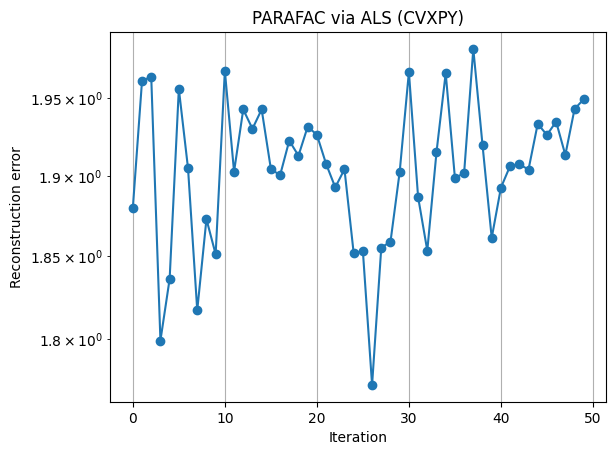

In [2]:
import numpy as np
import cvxpy as cp
from scipy.linalg import khatri_rao
import matplotlib.pyplot as plt

# --------------------------------------------------
# Tensor dimensions
# --------------------------------------------------
I, J, K, F = 3, 4, 5, 2
np.random.seed(0)

# Tensor
X = np.random.rand(I, J, K)

# --------------------------------------------------
# Mode-n unfoldings
# --------------------------------------------------
X1 = X.transpose().reshape(I, -1)      # (I, KJ)
X2 = X.transpose().reshape(J, -1)      # (J, KI)
X3 = X.transpose().reshape(K, -1)      # (K, JI)

# --------------------------------------------------
# Initialization (ONCE)
# --------------------------------------------------
A_val = np.random.rand(I, F)
B_val = np.random.rand(J, F)
C_val = np.random.rand(K, F)

# --------------------------------------------------
# CVXPY variables
# --------------------------------------------------
A = cp.Variable((I, F))
B = cp.Variable((J, F))
C = cp.Variable((K, F))

# --------------------------------------------------
# ALS loop
# --------------------------------------------------
max_iter = 50
errors = []

for it in range(max_iter):

    # ===== Update A =====
    Z = khatri_rao(C_val, B_val)   # (JK, F)
    problem_A = cp.Problem(cp.Minimize(cp.norm(X1 - A @ Z.T, 'fro')**2))
    A.value = A_val
    problem_A.solve(solver=cp.ECOS)
    A_val = A.value

    # ===== Update B =====
    # Para el Modo-2, usamos el producto de Khatri-Rao de C y A
    Z = khatri_rao(C_val, A_val)   # (KI, F)
    problem_B = cp.Problem(cp.Minimize(cp.norm(X2 - B @ Z.T, 'fro')**2))
    B.value = B_val
    problem_B.solve(solver=cp.ECOS)
    B_val = B.value

    # ===== Update C =====
    # Para el Modo-3, usamos el producto de Khatri-Rao de B y A
    Z = khatri_rao(B_val, A_val)   # (JI, F)
    problem_C = cp.Problem(cp.Minimize(cp.norm(X3 - C @ Z.T, 'fro')**2))
    C.value = C_val
    problem_C.solve(solver=cp.ECOS)
    C_val = C.value

    # ===== Normalize (important) =====
    for f in range(F):
        n = np.linalg.norm(A_val[:, f])
        if n > 0:
            A_val[:, f] /= n
            B_val[:, f] *= n

    # ===== Reconstruction error =====
    X_hat = np.einsum('if,jf,kf->ijk', A_val, B_val, C_val)
    err = np.linalg.norm(X - X_hat)
    errors.append(err)

    print(f"Iter {it:3d} | Reconstruction error: {err:.6e}")

# --------------------------------------------------
# Final results
# --------------------------------------------------
print("\nFinal factor matrices:")
print("A:\n", A_val)
print("B:\n", B_val)
print("C:\n", C_val)

# --------------------------------------------------
# Error plot
# --------------------------------------------------
plt.figure()
plt.plot(errors, marker='o')
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("Reconstruction error")
plt.title("PARAFAC via ALS (CVXPY)")
plt.grid(True)
plt.show()

## 3.2. Implementación del Modelo PARAFAC mediante Alternating Least Squares (ALS)

Iter   0 | Reconstruction error: 4.150112e-01
Iter   1 | Reconstruction error: 4.329788e-01
Iter   2 | Reconstruction error: 4.335630e-01
Iter   3 | Reconstruction error: 3.971344e-01
Iter   4 | Reconstruction error: 4.053482e-01
Iter   5 | Reconstruction error: 4.318192e-01
Iter   6 | Reconstruction error: 4.205366e-01
Iter   7 | Reconstruction error: 4.011454e-01
Iter   8 | Reconstruction error: 4.135074e-01
Iter   9 | Reconstruction error: 4.086989e-01
Iter  10 | Reconstruction error: 4.344150e-01
Iter  11 | Reconstruction error: 4.200797e-01
Iter  12 | Reconstruction error: 4.288649e-01
Iter  13 | Reconstruction error: 4.261178e-01
Iter  14 | Reconstruction error: 4.288693e-01
Iter  15 | Reconstruction error: 4.204864e-01
Iter  16 | Reconstruction error: 4.195660e-01
Iter  17 | Reconstruction error: 4.244380e-01
Iter  18 | Reconstruction error: 4.223222e-01
Iter  19 | Reconstruction error: 4.264093e-01
Iter  20 | Reconstruction error: 4.252793e-01
Iter  21 | Reconstruction error: 4

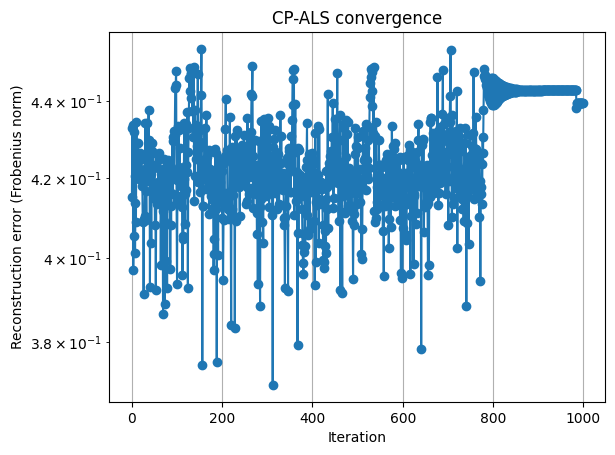

[np.float64(0.41501116305598207), np.float64(0.4329787559363217), np.float64(0.43356298706964863), np.float64(0.3971343966766769), np.float64(0.40534822873781773), np.float64(0.4318192455521006), np.float64(0.42053659891339623), np.float64(0.40114535663737483), np.float64(0.4135073999631765), np.float64(0.40869891086827637), np.float64(0.43441503467977577), np.float64(0.4200796874657542), np.float64(0.42886485132426444), np.float64(0.4261177501480032), np.float64(0.4288693185015718), np.float64(0.4204863718636032), np.float64(0.41956604244477247), np.float64(0.4244379850128114), np.float64(0.4223221807034167), np.float64(0.42640932969695694), np.float64(0.4252792759860845), np.float64(0.42117825061984654), np.float64(0.4178954927526817), np.float64(0.4204184003499768), np.float64(0.4088533501329251), np.float64(0.4091386531298625), np.float64(0.3913163056292589), np.float64(0.40962239206105805), np.float64(0.4104063985400222), np.float64(0.4200521929086175), np.float64(0.43421995351878

In [3]:


import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import khatri_rao

# -----------------------------
# Problem dimensions
# -----------------------------
I, J, K, F = 3, 4, 5, 2
np.random.seed(0)

# Tensor
X = np.random.rand(I, J, K)

# Mode-n unfoldings
X1 = X.transpose().reshape(I, -1)      # (I, KJ)
X2 = X.transpose().reshape(J, -1)      # (J, KI)
X3 = X.transpose().reshape(K, -1)      # (K, JI)

# -----------------------------
# Initialization
# -----------------------------
A = np.random.rand(I, F)
B = np.random.rand(J, F)
C = np.random.rand(K, F)

# -----------------------------
# CP-ALS
# -----------------------------
max_iter = 1000
tol = 1e-6
prev_error = np.inf
errors = []   # <-- store errors

for it in range(max_iter):

    # ---- Update A ----
    # Fijamos B y C. Z = C ⊙ B
    Z = khatri_rao(C, B)              # (KJ, F)
    # Resolvemos A * Z.T = X1 -> Z * A.T = X1.T
    A = np.linalg.lstsq(Z, X1.T, rcond=None)[0].T  # (I, F)

    # ---- Update B ----
    # Fijamos A y C. Z = C ⊙ A
    Z = khatri_rao(C, A)              # (KI, F)
    # Resolvemos B * Z.T = X2 -> Z * B.T = X2.T
    B = np.linalg.lstsq(Z, X2.T, rcond=None)[0].T  # (J, F)

    # ---- Update C ----
    # Fijamos A y B. Z = B ⊙ A
    Z = khatri_rao(B, A)              # (JI, F)
    # Resolvemos C * Z.T = X3 -> Z * C.T = X3.T
    C = np.linalg.lstsq(Z, X3.T, rcond=None)[0].T  # (K, F)

    # ---- Normalize columns (rest of your code...) ----

    # ---- Normalize columns ----
    for f in range(F):
        norm = np.linalg.norm(A[:, f])
        if norm > 0:
            A[:, f] /= norm
            B[:, f] *= norm

    # ---- Reconstruction error ----
    X_hat = np.einsum('if,jf,kf->ijk', A, B, C)
    error = np.linalg.norm(X - X_hat) / np.linalg.norm(X)
    errors.append(error)

    print(f"Iter {it:3d} | Reconstruction error: {error:.6e}")

    if abs(error) < tol:
        print(error)
        print('It is over')
        break

    prev_error = error

# -----------------------------
# Plot error evolution
# -----------------------------
plt.figure()
plt.plot(errors, marker='o')
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("Reconstruction error (Frobenius norm)")
plt.title("CP-ALS convergence")
plt.grid(True)
plt.show()

print(errors)




## 3.3. Implementación del Modelo PARAFAC mediante tensorly

In [1]:
pip install tensorly

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import tensorly as tl
from tensorly.decomposition import parafac

# Use NumPy backend
tl.set_backend('numpy')

# Tensor dimensions
I, J, K = 3, 4, 5
rank = 5

# Random tensor
X = np.random.rand(I, J, K)

# CP / PARAFAC decomposition
weights, factors = parafac(
    X,
    rank=rank,
    n_iter_max=100,
    tol=1e-6,
    init='random',
    normalize_factors=False,
    verbose=1
)

# Factors
A, B, C = factors

print("A shape:", A.shape)
print("B shape:", B.shape)
print("C shape:", C.shape)

from tensorly.cp_tensor import cp_to_tensor

X_hat = cp_to_tensor((weights, factors))

error = tl.norm(X - X_hat) / tl.norm(X)
print("Relative reconstruction error:", error)

reconstruction error=0.23533532497146142
iteration 1, reconstruction error: 0.179827844486541, decrease = 0.055507480484920435, unnormalized = 0.841005606015272
iteration 2, reconstruction error: 0.16523164765206458, decrease = 0.01459619683447641, unnormalized = 0.7727431887052776
iteration 3, reconstruction error: 0.1584958311973216, decrease = 0.006735816454742971, unnormalized = 0.7412416188805182
iteration 4, reconstruction error: 0.15490524251072643, decrease = 0.0035905886865951753, unnormalized = 0.724449418412656
iteration 5, reconstruction error: 0.1526709222714982, decrease = 0.0022343202392282324, unnormalized = 0.7140001142340421
iteration 6, reconstruction error: 0.15100937932344718, decrease = 0.0016615429480510147, unnormalized = 0.7062295326651203
iteration 7, reconstruction error: 0.14959486221594773, decrease = 0.0014145171074994578, unnormalized = 0.6996142233363107
iteration 8, reconstruction error: 0.14829104412829788, decrease = 0.001303818087649844, unnormalized

## 3.4. Tucker usando HOSVD

In [3]:
import numpy as np
from numpy.linalg import svd

# -----------------------------
# Tensor and Tucker ranks
# -----------------------------
I, J, K = 6, 5, 4
R1, R2, R3 = 3, 3, 2
np.random.seed(0)

X = np.random.rand(I, J, K)

# Mode-n unfoldings
X1 = X.transpose(0, 2, 1).reshape(I, -1)      # (I, KJ)
X2 = X.transpose(1, 2, 0).reshape(J, -1)      # (J, KI)
X3 = X.transpose(2, 1, 0).reshape(K, -1)      # (K, JI)

# SVDs
U1, _, _ = svd(X1, full_matrices=False)
U2, _, _ = svd(X2, full_matrices=False)
U3, _, _ = svd(X3, full_matrices=False)

A = U1[:, :R1]
B = U2[:, :R2]
C = U3[:, :R3]

# Core tensor
G = np.einsum('ia,jb,kc,ijk->abc', A, B, C, X)

# Reconstruction
X_hat = np.einsum('ia,jb,kc,abc->ijk', A, B, C, G)

error = np.linalg.norm(X - X_hat) / np.linalg.norm(X)
print("Reconstruction error (HOSVD):", error)

Reconstruction error (HOSVD): 0.35256378696432805


## 3.5 Tucker usando tensorly

In [4]:
import numpy as np
import tensorly as tl
from tensorly.decomposition import tucker
from tensorly.tucker_tensor import tucker_to_tensor

tl.set_backend('numpy')

# -----------------------------
# Tensor and Tucker ranks
# -----------------------------
I, J, K = 6, 5, 4
ranks = (4, 4, 4)
np.random.seed(0)

X = np.random.rand(I, J, K)

# Tucker decomposition
core, factors = tucker(
    X,
    rank=ranks,
    init='svd',
    n_iter_max=100,
    tol=1e-6
)

A, B, C = factors

# Reconstruction
X_hat = tucker_to_tensor((core, factors))

error =  tl.norm(X - X_hat) / tl.norm(X)
print("Reconstruction error (TensorLy Tucker):", error)

Reconstruction error (TensorLy Tucker): 0.20032628074348202
